# Pipelines

Pipelines are an integral part of river. We encourage their usage and apply them in many of their examples.

The `compose.Pipeline` contains all the logic for building and applying pipelines. A pipeline is essentially a list of estimators that are applied in sequence. The only requirement is that the first `n - 1` steps be transformers. The last step can be a regressor, a classifier, a clusterer, a transformer, etc. Here is an example:

In [1]:
from river import compose
from river import linear_model
from river import preprocessing
from river import feature_extraction

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    feature_extraction.PolynomialExtender(),
    linear_model.LinearRegression()
)

You can also use the `|` operator, as so:

In [2]:
model = (
    preprocessing.StandardScaler() |
    feature_extraction.PolynomialExtender() |
    linear_model.LinearRegression()
)

Or, equally:

In [3]:
model = preprocessing.StandardScaler() 
model |= feature_extraction.PolynomialExtender()
model |= linear_model.LinearRegression()

A pipeline has a `draw` method that can be used to visualize it:

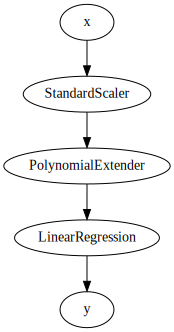

In [4]:
model.draw()

`compose.Pipeline` inherits from `base.Estimator`, which means that it has a `learn_one` method. You would expect `learn_one` to update each estimator, but **that's not actually what happens**. Instead, the transformers are updated when `predict_one` (or `predict_proba_one` for that matter) is called. Indeed, in online machine learning, we can update the unsupervised parts of our model when a sample arrives. We don't have to wait for the ground truth to arrive in order to update unsupervised estimators that don't depend on it. In other words, in a pipeline, `learn_one` updates the supervised parts, whilst `predict_one` updates the unsupervised parts. It's important to be aware of this behavior, as it is quite different to what is done in other libraries that rely on batch machine learning.

Here is a small example to illustrate the previous point:

In [5]:
from river import datasets

dataset = datasets.TrumpApproval()
x, y = next(iter(dataset))
x, y

({'ordinal_date': 736389,
  'gallup': 43.843213,
  'ipsos': 46.19925042857143,
  'morning_consult': 48.318749,
  'rasmussen': 44.104692,
  'you_gov': 43.636914000000004},
 43.75505)

Let us call `predict_one`, which will update each transformer, but won't update the linear regression.

In [6]:
model.predict_one(x)

0.0

The prediction is nil because each weight of the linear regression is equal to 0.

In [7]:
model['StandardScaler'].means

defaultdict(float,
            {'ordinal_date': 736389.0,
             'gallup': 43.843213,
             'ipsos': 46.19925042857143,
             'morning_consult': 48.318749,
             'rasmussen': 44.104692,
             'you_gov': 43.636914000000004})

As we can see, the means of each feature have been updated, even though we called `predict_one` and not `learn_one`.

Note that if you call `transform_one` with a pipeline who's last step is not a transformer, then the output from the last transformer (which is thus the penultimate step) will be returned:

In [8]:
model.transform_one(x)

{'ordinal_date': 0.0,
 'gallup': 0.0,
 'ipsos': 0.0,
 'morning_consult': 0.0,
 'rasmussen': 0.0,
 'you_gov': 0.0,
 'ordinal_date*ordinal_date': 0.0,
 'gallup*ordinal_date': 0.0,
 'ipsos*ordinal_date': 0.0,
 'morning_consult*ordinal_date': 0.0,
 'ordinal_date*rasmussen': 0.0,
 'ordinal_date*you_gov': 0.0,
 'gallup*gallup': 0.0,
 'gallup*ipsos': 0.0,
 'gallup*morning_consult': 0.0,
 'gallup*rasmussen': 0.0,
 'gallup*you_gov': 0.0,
 'ipsos*ipsos': 0.0,
 'ipsos*morning_consult': 0.0,
 'ipsos*rasmussen': 0.0,
 'ipsos*you_gov': 0.0,
 'morning_consult*morning_consult': 0.0,
 'morning_consult*rasmussen': 0.0,
 'morning_consult*you_gov': 0.0,
 'rasmussen*rasmussen': 0.0,
 'rasmussen*you_gov': 0.0,
 'you_gov*you_gov': 0.0}

In many cases, you might want to connect a step to multiple steps. For instance, you might to extract different kinds of features from a single input. An elegant way to do this is to use a `compose.TransformerUnion`. Essentially, the latter is a list of transformers who's results will be merged into a single `dict` when `transform_one` is called. As an example let's say that we want to apply a `feature_extraction.RBFSampler` as well as the `feature_extraction.PolynomialExtender`. This may be done as so:

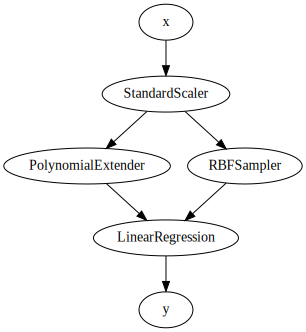

In [9]:
model = (
    preprocessing.StandardScaler() |
    (feature_extraction.PolynomialExtender() + feature_extraction.RBFSampler()) |
    linear_model.LinearRegression()
)

model.draw()

Note that the `+` symbol acts as a shorthand notation for creating a `compose.TransformerUnion`, which means that we could have declared the above pipeline as so:

In [10]:
model = (
    preprocessing.StandardScaler() |
    compose.TransformerUnion(
        feature_extraction.PolynomialExtender(),
        feature_extraction.RBFSampler()
    ) |
    linear_model.LinearRegression()
)

Pipelines provide the benefit of removing a lot of cruft by taking care of tedious details for you. They also enable to clearly define what steps your model is made of. Finally, having your model in a single object means that you can move it around more easily. Note that you can include user-defined functions in a pipeline by using a `compose.FuncTransformer`.